In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

### Importing data and taking what's relevant

When importing a file from GitHub, either:
1. "?raw=true" need to be added to the url
2. click the "raw" button and use that url

##### Hospitalized and Infected Table

In [3]:
url = "https://github.com/dancarmoz/israel_moh_covid_dashboard_data/blob/master/hospitalized_and_infected.csv?raw=true"
cases = pd.read_csv(url)

cases['Date'] = pd.to_datetime(cases['Date'], format='%Y-%m-%d') #parsing dates
cases = cases.loc[:,['Date','New infected','Hospitalized','Official R','Epidemiological Event', 'New deaths']] #extracting columns

##### Vaccinated Table

In [4]:
url = "https://github.com/dancarmoz/israel_moh_covid_dashboard_data/blob/master/vaccinated.csv?raw=true"
vaccinated = pd.read_csv(url)

vaccinated['Date'] = pd.to_datetime(vaccinated['Date'], format='%Y-%m-%d') #parsing dates
vaccinated = vaccinated.loc[:,['Date','Vaccinated (daily)','Second dose (daily)','Third dose (daily)']] #extracting columns
vaccinated.rename(columns={"Vaccinated (daily)":"First dose (daily)"}, inplace=True)

##### Merge

In [5]:
data = cases.merge(vaccinated, how = 'outer', on= ['Date'])
data.set_index('Date', inplace=True)
data.tail()

,New infected,Hospitalized,Official R,Epidemiological Event,New deaths,First dose (daily),Second dose (daily),Third dose (daily)
Date,,,,,,,,
2022-01-06,17082,529,NaN,NaN,1,8360.0,7753.0,13372.0
2022-01-07,18995,555,NaN,NaN,2,4774.0,4518.0,8033.0
2022-01-08,17723,626,NaN,NaN,1,2748.0,2428.0,5434.0
2022-01-09,21514,730,NaN,NaN,1,9321.0,7717.0,11710.0
2022-01-10,6409,608,NaN,NaN,0,1042.0,1220.0,3011.0


In [6]:
today = datetime.date.today() #edit the date format

last_week = data.tail(7)
last_month = data.tail(30)

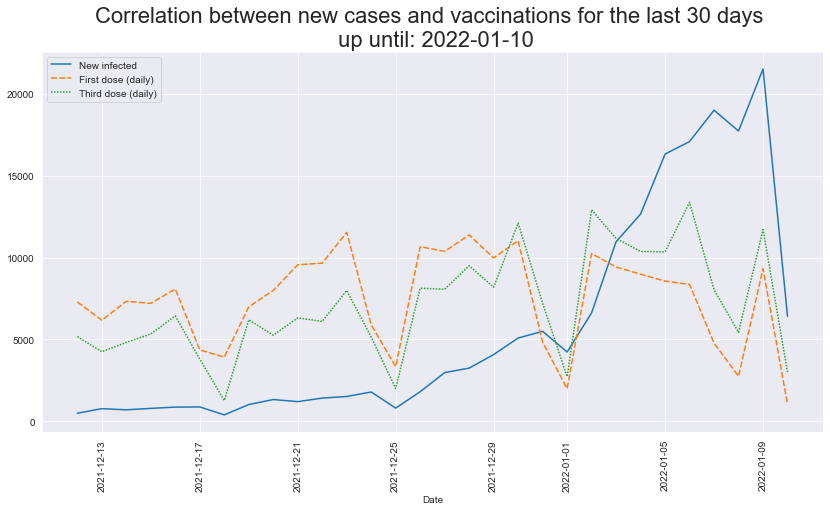

In [7]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,1, figsize=(14,7))
ax.set_title('Correlation between new cases and vaccinations for the last 30 days \n up until: {}'.format(today), size = 22)

sns.lineplot(data = last_month[['New infected', 'First dose (daily)', 'Third dose (daily)']])
plt.xticks(rotation=90)
#plt.savefig ("Month_correlation {}.png".format(today),bbox_inches ="tight", dpi=100)
plt.show()

#### Add daily change in percentage

In [8]:
data_num = data.drop(['Epidemiological Event'], axis=1)
data_num = data_num.replace(0,None) #replacing values of '0' with 'None' replaces them with the value of the cell above
                                    #meaning that a day with 0 infections does not make a difference 
                                    #otherwise it would create a problem with the previous and following cells' calculations
                                    #num/0=undefined and 0/num=0

d_change = round(data_num/data_num.shift(1)*100) #the rario in percent of change by day - dividing each data point 
                                                 #by that of the previous day's to see how much it has changed
d_change.tail()

,New infected,Hospitalized,Official R,New deaths,First dose (daily),Second dose (daily),Third dose (daily)
Date,,,,,,,
2022-01-06,105.0,108.0,NaN,33.0,98.0,136.0,129.0
2022-01-07,111.0,105.0,NaN,200.0,57.0,58.0,60.0
2022-01-08,93.0,113.0,NaN,50.0,58.0,54.0,68.0
2022-01-09,121.0,117.0,NaN,100.0,339.0,318.0,215.0
2022-01-10,30.0,83.0,NaN,100.0,11.0,16.0,26.0


In [9]:
#growth ratio replaced by percentage

for column in d_change.columns: #loop over all of the columns in the dataframe
    d_change[column] = d_change[column].apply(lambda x: 0 if x == 100 else x-100) #applying function on all the rows 
                                                                                  #in a given column
    #translating change ratio into growth:
        #when the ratio is 100 (meaning no change) the growth will be 0
        #when the ratio is over 100 (positive growth) the growth increase is of (x-100) percent
        #when the ratio is lesser than 100 (negative growth, positive number) the growth decrease is also of (x-100) percent
            #it's the same as saying that 30% of a number is the number minus 70%
            #30% of 120 is 36, 120-70%(of 120) is also 36
            
d_change.tail()

,New infected,Hospitalized,Official R,New deaths,First dose (daily),Second dose (daily),Third dose (daily)
Date,,,,,,,
2022-01-06,5.0,8.0,NaN,-67.0,-2.0,36.0,29.0
2022-01-07,11.0,5.0,NaN,100.0,-43.0,-42.0,-40.0
2022-01-08,-7.0,13.0,NaN,-50.0,-42.0,-46.0,-32.0
2022-01-09,21.0,17.0,NaN,0.0,239.0,218.0,115.0
2022-01-10,-70.0,-17.0,NaN,0.0,-89.0,-84.0,-74.0


In [10]:
last_week_change = d_change.tail(7)
last_month_change = d_change.tail(30)

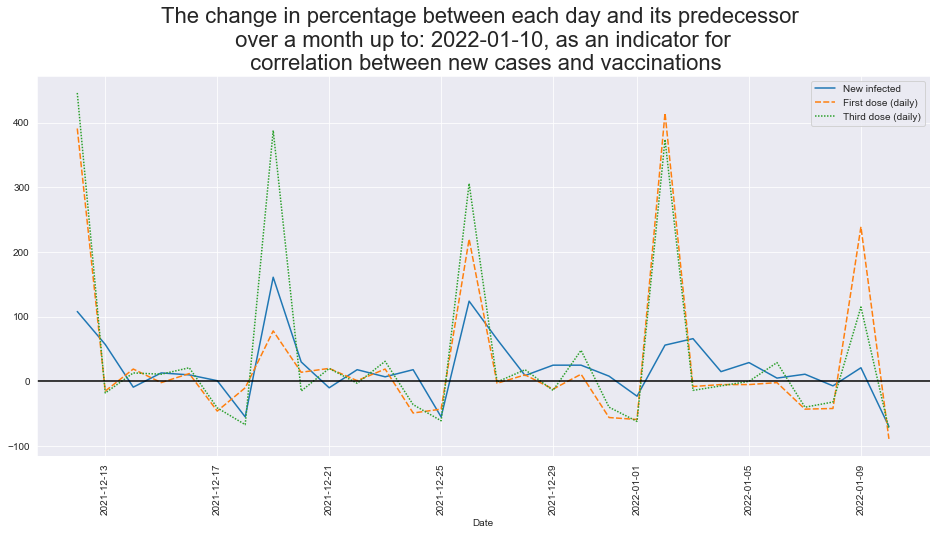

In [11]:
sns.set_style("darkgrid")
fig, ax = plt.subplots(1,1, figsize=(16,7))
ax.set_title('The change in percentage between each day and its predecessor \n over a month up to: {}, as an indicator for \n correlation between new cases and vaccinations'.format(today), size = 22)

sns.lineplot(data = last_month_change[['New infected', 'First dose (daily)', 'Third dose (daily)']])
plt.xticks(rotation=90)
plt.axhline(0, color = 'black')

#plt.savefig ("Month_correlation_percentage {}.png".format(today),bbox_inches ="tight", dpi=100)
plt.show()

In [12]:
last_month_change[['New infected', 'First dose (daily)', 'Third dose (daily)']].corr()

,New infected,First dose (daily),Third dose (daily)
New infected,1.000000,0.555536,0.772823
First dose (daily),0.555536,1.000000,0.881045
Third dose (daily),0.772823,0.881045,1.000000


### trying to apply machine learning (decision tree model)

hospitalized and new deaths prediction

In [24]:
data[['Hospitalized', 'New deaths']].corr() #we can see they are highly corrolated, if we don't take into
                                                     #account the different varients

,Hospitalized,New deaths
Hospitalized,1.00000,0.93009
New deaths,0.93009,1.00000


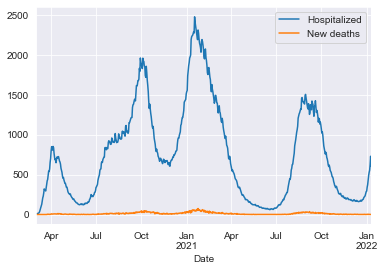

In [25]:
data[['Hospitalized', 'New deaths']].plot()
plt.show()

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [15]:
X = data['Hospitalized'] #a series as the undependent/feature has to ve reshaped like this
y = data['New deaths']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=1) #remember the order of train and test
rf_model = RandomForestRegressor(random_state=1)
rf_model.fit(X_train.values.reshape(-1, 1), y_train)
predictions = rf_model.predict(X_test.values.reshape(-1, 1)) #predict only based on the X_test values


In [16]:
val_mae = mean_absolute_error(predictions, y_test)
print("On average, my predictions are off by about: {:,.0f} deaths".format(val_mae))

print("My test score is: {}".format (round(rf_model.score(X_test.values.reshape(-1, 1) ,y_test),3)))

On average, my predictions are off by about: 3 deaths
My test score is: 0.897


In [26]:
hostp = input ("how many are hospitalized? ")
dead = rf_model.predict([[hostp]]) #insert a number of hospitalized and the model will predict the number of dead
print ("The estimated dead will number {}".format(round(dead[0], 3))) 

how many are hospitalized? 600
The estimated dead will number 8.79


In [18]:
data.loc[:,['Hospitalized','New deaths']].head(600).tail(10)

,Hospitalized,New deaths
Date,,
2021-10-13,697,9
2021-10-14,665,13
2021-10-15,621,10
2021-10-16,601,9
2021-10-17,620,7
2021-10-18,594,11
2021-10-19,553,3
2021-10-20,540,8
2021-10-21,527,7


In [19]:
def dead_by_hosp (num):
    dead = rf_model.predict([[num]])
    return (round(dead[0], 3))

In [20]:
vals = range(0, 2501, 100)
df = pd.DataFrame (vals, columns = ['hospitalized'])
df['dead_predict'] = [dead_by_hosp(x) for x in df['hospitalized']] #making a new column with my function and
                                                                   #list comprehension (sends one item each time)
df

,hospitalized,dead_predict
0,0,0.005
1,100,0.857
2,200,2.745
3,300,2.100
4,400,9.560
5,500,5.644
6,600,8.790
7,700,8.064
8,800,10.463
9,900,14.110


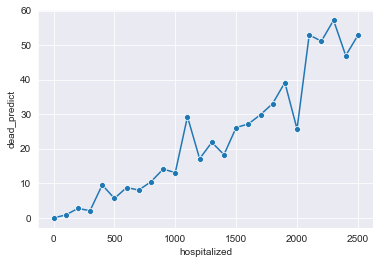

In [21]:
sns.lineplot (x=df['hospitalized'], y=df['dead_predict'], marker = 'o')
plt.show()

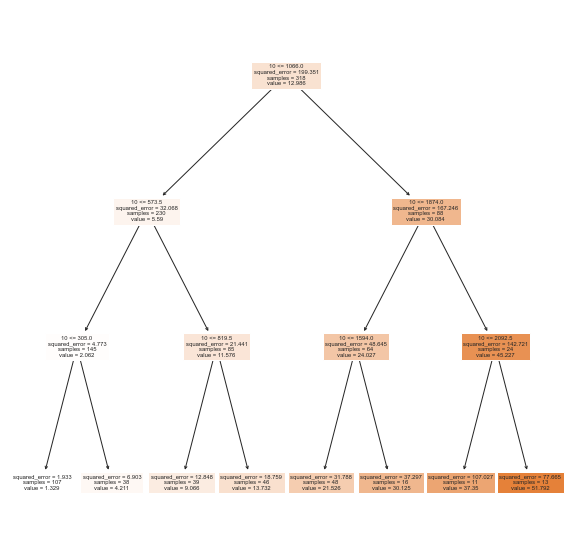

In [22]:
from sklearn import tree

rf = RandomForestRegressor(n_estimators=100, max_depth=3) #creating new random forest with max nodes of 3
rf.fit(X_train.values.reshape(-1, 1), y_train) 


plt.figure(figsize=(10,10))
tree.plot_tree(rf.estimators_[0], feature_names=X, filled=True) #plotting the tree of the 1st tree in the forest
plt.show()